In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random
import string
import multiprocessing as mp

In [2]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [3]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  STI6WR1Z_15_57_37
NN-MODEL FILENAME:  STI6WR1Z_15_57_37_NN.pt


In [4]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [ ]:
def discretize(c_pos_val, c_vel_val, p_ang_val, p_vel_val, c_pos_s, c_vel_s, p_ang_s, p_vel_s):
    c_pos_indx = np.where(c_pos_s >= c_pos_val)[0][0].astype(int)
    c_vel_indx = np.where(c_vel_s >= c_vel_val)[0][0].astype(int)
    p_ang_indx = np.where(p_ang_s >= p_ang_val)[0][0].astype(int)
    p_vel_indx = np.where(p_vel_s >= p_vel_val)[0][0].astype(int)
    return [c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx]

In [ ]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 4
NO_OF_EPISODES = 5
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  4
Number of EPISODES per NODE 5


In [ ]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 20000

In [ ]:
MAX_NO_OF_ITERATIONS = 3
MAX_NN_ITERATIONS    = 7000

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(self.good_memory.shape[0]), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(self.bad_memory.shape[0]),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
class DDQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros(N_STATES*2+2)#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(self.good_memory.shape[0]), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(self.bad_memory.shape[0]),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [ ]:
dqn = DDQN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [ ]:
def mp_node_run(node_id):
    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################

    # SET STATE VALUE_LIMITS
    ###############################################
    C_POS_MAX =  5
    C_POS_MIN = -5

    C_VEL_MAX =  5
    C_VEL_MIN = -5

    P_ANG_MAX =  1
    P_ANG_MIN = -1

    P_VEL_MAX =  5
    P_VEL_MIN = -5
    ###############################################

    # SET GRANULARITY
    GRANULARITY = 50

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s = np.linspace(C_POS_MIN, C_POS_MAX, GRANULARITY)
    c_vel_s = np.linspace(C_VEL_MIN, C_VEL_MAX, GRANULARITY)
    p_ang_s = np.linspace(P_ANG_MIN, P_ANG_MAX, GRANULARITY)
    p_vel_s = np.linspace(P_VEL_MIN, P_VEL_MAX, GRANULARITY)
    ###############################################

    # CREATE STATE COMBINATIONS
    ###############################################

    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN],
                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX],
                                GRANULARITY)
    ###############################################

    my_dqn = DQN()
    my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    my_dqn.eval_net.eval()
    my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(GRANULARITY,GRANULARITY,GRANULARITY,GRANULARITY,-1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    my_EPSILON   = T_EPSILON
    my_LR        = T_LR

    while True:
        i_episode = 0

        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

            s = my_env.reset()
            while True:
                [c_pos_state, 
                c_vel_state, 
                p_ang_state, 
                p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                         c_pos_s, 
                                         c_vel_s, 
                                         p_ang_s, 
                                         p_vel_s)
                time_steps += 1
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1

                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                [next_c_pos_state, 
                next_c_vel_state, 
                next_p_ang_state, 
                next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                              c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

                # learn
                this_state = tuple([c_pos_state, 
                              c_vel_state, 
                              p_ang_state, 
                              p_vel_state])

                next_state = tuple([ next_c_pos_state, 
                               next_c_vel_state, 
                               next_p_ang_state, 
                               next_p_vel_state])

                my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - 
                                                                         my_Q_TABLE[this_state][a])
                if done:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

    #             #TO LEVEL UP    
    #             if np.mean(time_rec[-10:]) > level_up_metric:
    #                 PERFECT_RUN_COUNTER += 1
    #             else:
    #                 PERFECT_RUN_COUNTER = 0

    #             if PERFECT_RUN_COUNTER > PERFECT_RUNS_HIGH_SCORE:
    #                 PERFECT_RUN_COUNTER = 0
    #                 PERFECT_RUNS_HIGH_SCORE *= 1.5
    #                 my_LR *= 0.1
    #                 if my_EPSILON < 0.99:
    #                     my_EPSILON += 0.02

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
    #     message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
    #     print(message)
    return exp_rec, time_rec



ITERATION # 0
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 0: 68
REAL TIME TO GENERATE 919 EXPERIENCES:0:00:06.733925


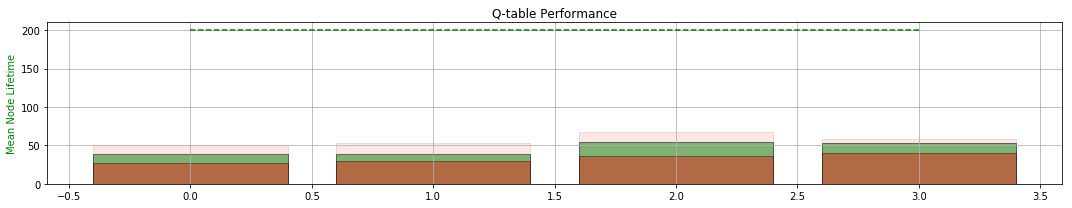

Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  77.66
Validating... MEAN TIME:  126.315
Validating... MEAN TIME:  75.485
Validating... MEAN TIME:  58.66
Validating... MEAN TIME:  57.95
TRAINING TIME:0:00:33.063057


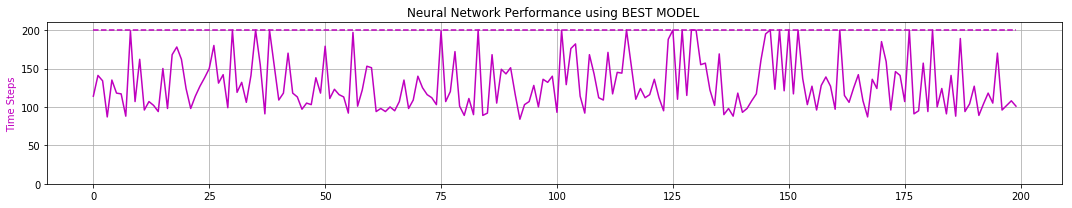



ITERATION # 1
TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
LARGEST TIMESTEP in ITERATION 1: 200
REAL TIME TO GENERATE 1908 EXPERIENCES:0:00:06.955425


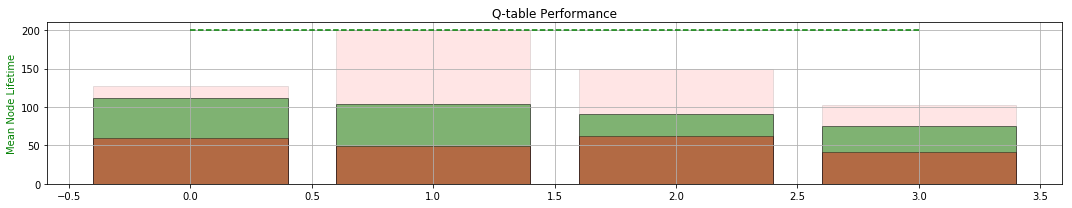

Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... 

In [ ]:
iteration = 0
dqn = DDQN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# Create a pool of processes
pool = mp.Pool(NO_OF_NODES)

while iteration < MAX_NO_OF_ITERATIONS:
    print("\n")
    print("ITERATION #", iteration)
    print("TABULAR EPSILON = ", T_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()

    # Map aigym environment to each process
    args = range(NO_OF_NODES)
    result = pool.map(mp_node_run, args)
    
    node_time_rec = np.array([item[1] for item in result])
    node_exp = np.array([item[0] for item in result ])
    all_exp = np.array([item for each_node_exp in node_exp 
                                for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,10)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("LARGEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.max().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    
    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    #segregate experiences
    good_mem = all_exp[all_exp[:,5] == 1]
    bad_mem  = all_exp[all_exp[:,5]  < 1]
    
    dqn.good_memory = good_mem
    dqn.bad_memory = bad_mem
    
    NN_ITERATIONS = MAX_NN_ITERATIONS

    #learn
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    
    best_dqn = DDQN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()
    
    #test NN policy using BEST MODEL
    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()
        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()

    iteration += 1

pool.close()
pool.join()

In [ ]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))